In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import calendar
import datetime as dt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.seasonal import STL

In [49]:
style.use('fivethirtyeight')
sns.set_palette('colorblind')

first let's go ahead and define our model's fit and transform functions

In [50]:
def separate_endog_and_exog(df, endog, exog):
        endog_data = df[endog]
        exog_data = df[exog]

        # convert dfs to matrices
        x = exog_data.to_numpy()
        y = endog_data.to_numpy()

        return x, y

In [51]:
def psi_weights(phi, lag):
        k = phi.shape[0]
        m = phi.shape[1]
        p = np.floor(m/k)
        si = np.zeros((k, k))
        np.fill_diagonal(si, 1)
        if (p < 1):
            p = 1
        if (lag < 1):
            lag = 1
        
        for i in range(1, (lag+1)):
            if (i < (p+1)):
                id_x = (i-1) * k
                t_p = phi[:, id_x:(id_x+k)]
            else:
                t_p = np.zeros((k, k))
            jj = i-1
            jp = np.minimum(jj, p).astype(int)
            if (jp > 0):
                for j in range(1, (jp+1)):
                    jd_x = (j-1) * k
                    id_x = (i-j) * k
                    w1 = phi[:, jd_x:(jd_x+k)]
                    w2 = si[:, id_x:(id_x+k)]
                    t_p = t_p + np.dot(w1, w2)
            si = np.concatenate((si, t_p), axis=1)
        
        return si

In [52]:
def plot_irf(wk, acuwk, lag, orthog=True, cumulative=True):
    td_x = np.array(range(lag+1))

    if (~cumulative):
        plt_data = wk
        plt_title = 'Cumulative Impulse Responses'
    else:
        plt_data = acuwk
        plt_title = 'Impulse Responses'

    # plot impulse responses
    for i in range(plt_data.shape[0]):
        plt.subplot((plt_data.shape[0]+1), 1, (i+1))
        x_data = plt_data[i]
        plt.plot(td_x, x_data, 'o-')
        plt.ylabel(str(i))
        
    plt.xlabel('Periods')
    if (orthog):
        plt_title = 'Orthogonal ' + plt_title
    plt.title(plt_title)
    plt.show()

In [53]:
def fit(df, endog, exog, lag, x_lag, include_mean=True, fixed=np.NaN):
        x, y = separate_endog_and_exog(df, endog, exog)
        p = lag
        m = x_lag

        # calculate dimensions for exogenous variables
        if x.shape[1] < 1:
            m = -1
            k_x = 0
        else:
            k_x = x.shape[1]
        # validate lags are non-negative
        if p < 0:
            p = 0

        ist = np.max([p, m])
        n_t = y.shape[0]
        k = y.shape[1]
        y_t = y[ist:n_t, ]

        xmtx = np.NaN

        if include_mean:
            xmtx = np.ones(n_t - ist + 1)

        # let's define the columns so that we can keep track of which values are for which columns
        cols = endog
        cols_exog = exog
        
        # add in the lags for endog variables
        if p > 0:
            for i in range(p):
                xmtx = np.concatenate((xmtx, y[(ist-i-1):(n_t-i-1),]), axis=1)
                if i > 0:
                    new_cols = [c + '_l' + str(i) for c in endog]
                    # update list of column names
                    cols = np.concatenate([new_cols, cols])
        # add in the lags for exog variables
        if m > -1:
            for i in range(m+1):
                xmtx = np.concatenate((xmtx, x[(ist-i):(n_t-i),]), axis=1)
                # update exog column names
                if i > 0:
                    new_cols_exog = [c + '_l' + str(i) for c in exog]
                    cols_exog = np.concatenate([new_cols_exog, cols_exog])

        # update entire set of columns
        cols = np.concatenate([cols, cols_exog])
        cols = np.concatenate([['intercept'], cols])

        p_1 = xmtx.shape[1]
        nobe = xmtx.shape[0]

        beta = np.zeros((p_1, k))
        se_beta = np.ones((p_1, k))
        resi = y_t
        n_par = 0

        if (np.isnan(fixed)):
            xpx = np.dot(xmtx.T, xmtx)
            xpx = xpx.astype(float)
            xpy = np.dot(xmtx.T, y_t)
            xpxi = np.linalg.solve(xpx)
            beta = np.dot(xpxi, xpy)
            resi = y_t - np.dot(xmtx, beta)
            sig = np.matmul(resi.T, resi) / nobe
            co = np.kron(sig, xpxi)
            co_diag = np.diag(co)
            se = co_diag**(1/2)
            se_beta = se.reshape((beta.shape[0], k), order='F')
            n_par = beta.shape[0] * k
            sig = sig.astype(float)
            sig_det = np.linalg.det(sig)
            d_1 = np.log(sig_det)
            aic = d_1 + 2 * n_par / nobe
            bic = d_1 + np.log(nobe) * n_par / nobe
        else:
            beta = np.zeros((p_1, k))
            se_beta = np.ones((p_1, k))
            resi = y_t
            n_par = 0
            for i in range(k):
                id_x = np.argwhere(np.any(fixed[:, i] == 1))
                n_par = n_par + len(id_x)
                if (len(id_x) > 0):
                    x_m = xmtx[:, id_x]
                    y_1 = y_t[:, i].reshape((nobe, 1))
                    xpx = np.dot(x_m.T, x_m)
                    xpy = np.dot(x_m.T, y_1)
                    xpx = xpx.astype(float)
                    xpxi = np.linalg.solve(xpx)
                    beta_1 = np.dot(xpxi, xpy)
                    res = y_1 - np.dot(x_m, beta_1)
                    sig_1 = np.sum(res**2) / nobe
                    sig_1 = sig_1.astype(float)
                    diag_sig_1 = np.diag(xpxi) * sig_1
                    se = diag_sig_1**(1/2)
                    beta[id_x, i] = beta_1
                    se_beta[id_x, i] = se
                    resi[:, i] = res
            sig = np.matmul(resi.T, resi) / nobe
            sig = sig.astype(float)
            d_1 = np.log(np.linalg.det(sig))
            aic = d_1 + 2 * n_par / nobe
            bic = d_1 + np.log(nobe) * n_par / nobe
        
        ph0 = np.NaN
        icnt = 0

        if (include_mean):
            ph0 = beta[0,:]
            icnt = icnt + 1
            print('Constant Term:')
            print('est:', [np.round(i, 4) for i in ph0])
            print('se:', [np.round(i, 4) for i in se_beta[0,:]])
        
        phi = np.NaN

        if (p > 0):
            phi = beta[(icnt):(icnt+k*p),].T
            se_phi = se_beta[(icnt):(icnt+k*p),].T
            for i in range(1, p+1):
                print('AR(' + str(i) + ') matrix:')
                jcnt = (i-1) * k
                print('\n'.join([' '.join(['{:.3f}'.format(item) for item in row]) for row in phi[:,jcnt:(jcnt+k)]]))
                print('standard errors:')
                print('\n'.join([' '.join(['{:.3f}'.format(item) for item in row]) for row in se_phi[:,jcnt:(jcnt+k)]]))
            icnt = icnt + k * p

        if (m > -1):
            print('coefficients of exogenous variables:')
            beta_exog = beta[icnt:icnt+(m+1)*k_x,:].T
            se_beta_exog = se_beta[icnt:icnt+(m+1)*k_x,:].T
            if (k_x == 1):
                beta_exog = beta_exog.T
                se_beta_exog = se_beta_exog.T
            for i in range(m):
                jdx = i * k_x
                print('l' + str(i), 'coefficient matrix')
                print('\n'.join([' '.join(['{:.3f}'.format(item) for item in row]) for row in beta_exog[:,jdx:(jdx+k_x)]]))
                print('standard errors:')
                print('\n'.join([' '.join(['{:.3f}'.format(item) for item in row]) for row in se_beta_exog[:,jdx:(jdx+k_x)]]))

        print('Residual Covariance Matrix:')
        print('\n'.join([' '.join(['{:.5f}'.format(item) for item in row]) for row in sig]))
        print('Information Criteria:')
        print('AIC:', '{:.3f}'.format(aic))
        print('BIC:', '{:.3f}'.format(bic))

        return y, x, beta, se_beta, resi, sig, beta_exog, ph0, phi, cols, cols_exog

In [54]:
def transform(y, x, lag, x_lag, beta, ph0, phi, sig, step, new_x=np.NaN, origin=0):

    n_t = y.shape[0]
    k = y.shape[1]
    dim_x = x.shape[1]
    se = np.NaN
    ph0 = ph0.reshape((3, 1))

    if (len(ph0) < 1):
        ph0 = np.zeros(k, 1)
    if (step < 1):
        step = 1
    if (origin < 1):
        origin = n_t
    
    if (~np.isnan(new_x)):
        # estimate values
        step = np.min([new_x.shape[0], step])
        y_new = y[0:origin]
        if (dim_x > 1):
            x = np.concatenate((x[0:origin], new_x), axis=0)

        for i in range(step):
            t_p = ph0
            t_i = origin + i
            for i in range(1, lag):
                id_x = (i-1) * lag
                t_p = t_p + np.dot(phi[:, (id_x+1):(id_x+k)], y_new[t_i-i, :].reshape(dim_x, 1))
            if (x_lag > -1):
                for i in range(x_lag):
                    id_x = i * dim_x
                    t_p = t_p + np.dot(beta[:, (id_x+1):(id_x+dim_x)], x[t_i-i, :].reshape(dim_x, 1))
            y_new = np.concatenate((y_new, t_p), axis=0)

        # standard errors of predictions
        weights = psi_weights(phi, step)
        se = np.diag(sig)**(1/2)
        se = se.reshape(1, k)
        if step > 1:
            for i in range(2, step):
                id_x = (i-1) * k
                wk = weights[:, id_x:(id_x+k)]
                si = si + np.linalg.multi_dot([wk, sig, wk.T])
                se1 = np.diag(si)**(1/2)
                se1 = se1.reshape(1, k)
                se = np.concatenate((se, se1), axis=0)

        print('Prediction at Origin:', origin)
        print('Point forecasts:')
        print('\n'.join([' '.join(['{:.4f}'.format(item) for item in row]) for row in y_new[:, (origin+1):(origin+step)]]))
        print('Standard errors:')
        print('\n'.join([' '.join(['{:.4f}'.format(item) for item in row]) for row in se[0:step,:]]))
    
    return y_new, se

In [55]:
def irf(beta_exog, sig, phi, p, x_lag, cumulative_irf, lag=12, orthog=True):

    m = x_lag
    k = phi.shape[0]
    si = np.diag(np.ones(k))
    wk = si.reshape((1, 9))
    awk = wk
    acuwk = awk

    if (p < 1):
        p = 1
    if (m < 1):
        m=1

    for i in range(1, (lag+1)):
        if (i < (p+1)):
            id_x = (i-1) * k
            t_p = phi[:, id_x:(id_x+k)]
        else:
            t_p = np.zeros((k, k))
        jj = i-1
        jp = np.minimum(jj, p).astype(int)
        if (jp > 0):
            for j in range(1, (jp+1)):
                jd_x = (j-1) * k
                id_x = (i-j) * k
                w1 = phi[:, jd_x:(jd_x+k)]
                w2 = si[:, id_x:(id_x+k)]
                t_p = t_p + np.dot(w1, w2)
        si = np.concatenate((si, t_p), axis=1)
        wk = np.concatenate((wk, t_p.reshape((1, t_p.size))), axis=1)
        awk = awk + t_p.reshape((1, t_p.size), order='F')
        acuwk = np.concatenate((acuwk, awk), axis=0)
        acuwk = acuwk.T
    
    orsi = np.NaN
    wk1 = np.NaN
    awk1 = np.NaN
    acuwk = np.NaN

    if (orthog):
        m1 = np.linalg.cholesky(sig)
        p1 = m1
        if (~np.isnan(wk1)):
            wk1 = np.concatenate((wk1, p1), axis=1)
        else:
            wk1 = p1.reshape((p1.size, 1), order='F')
        awk1 = wk1
        acuwk1 = awk1
        if (~np.isnan(orsi)):
            orsi = np.concatenate((orsi, p1), axis=1)
        else:
            orsi = p1
        for i in range(1, p+1):
            id_x = i*k
            w1 = si[:, id_x:(id_x+k)]
            w2 = np.dot(w1, p1)
            orsi = np.concatenate((orsi, w2), axis=1)
            wk1 = np.concatenate((wk1, w2.reshape((w2.size, 1), order='F')), axis=1)
            awk1 = awk1 + w2.reshape((w2.size, 1), order='F')
            acuwk1 = np.concatenate((acuwk1, awk1), axis=1)
    
    if (orthog):
        plot_irf(wk=wk1, acuwk=acuwk1, lag=p, cumulative=cumulative_irf)
    else:
        plot_irf(wk=wk, acuwk=acuwk, lag=p, orthog=orthog, cumulative=cumulative_irf)

    kx = int(np.floor(beta_exog.shape[1] / (1 + m)))
    psi_x = beta_exog[:, 0:kx]
    wk = psi_x.reshape((1, psi_x.size), order='F')
    awk = wk
    acuwk = awk
    for i in range(1, lag+1):
        if (i < (m+1)):
            id_x = (i-1) * kx
            t_p = beta_exog[:, id_x:(id_x+kx)]
        else:
            t_p = np.zeros((k, kx))
        jj = i-1
        jp = np.minimum(jj, p).astype(int)
        if (jp > 0):
            for j in range(1, (jp+1)):
                jd_x = (j-1) * k
                id_x = (i-j) * k
                w1 = phi[:, jd_x:(jd_x+k)]
                w2 = si[:, id_x:(id_x+kx)]
                t_p = t_p + np.dot(w1, w2)
        psi_x = np.concatenate((psi_x, t_p), axis=1)
        wk = np.concatenate((wk, t_p.reshape((1, t_p.size))), axis=1)
        awk = awk + t_p.reshape((1, t_p.size), order='F')
        acuwk = np.concatenate((acuwk, awk), axis=0)

    if (orthog):
        plot_irf(wk=wk1, acuwk=acuwk1, lag=p, cumulative=cumulative_irf)
    else:
        plot_irf(wk=wk, acuwk=acuwk, lag=p, orthog=orthog, cumulative=cumulative_irf)

    # lastly just return the values for the irfs
    return si, orsi, psi_x

In [56]:
df = pd.read_excel('../data/master-data.xlsx')
df.head()

,Unnamed: 0,month,population,price,price_adj,bulk,bottled,cider,effervescent,wine_gross,...,landed_duty_paid_value_ukfrspde_imports,landed_duty_paid_value_adj_ukfrspde_imports,customs_value_ukfrspde_imports,customs_value_adj_ukfrspde_imports,quantity_ukfrspde_imports,charges_insurance_freight_ukfrspde_imports,charges_insurance_freight_adj_ukfrspde_imports,calculated_duties_ukfrspde_imports,calculated_duties_adj_ukfrspde_imports,frspger_25
0,0,2000-01-31,281083000,5.458,5.299029,1.131505e+08,1.244070e+08,NaN,6.909175e+06,2.444667e+08,...,59812261,5.807016e+07,56706027,5.505440e+07,8768676,2406931,2.336826e+06,699303,678934.951456,0
1,1,2000-02-29,281299000,5.256,5.198813,7.179357e+07,1.375283e+08,NaN,4.377026e+06,2.136989e+08,...,77087577,7.624884e+07,73873201,7.306944e+07,8961916,2356486,2.330847e+06,857890,848555.885262,0
2,2,2000-03-31,281531000,5.471,5.311650,4.635628e+07,1.603837e+08,NaN,9.321474e+06,2.160614e+08,...,87219165,8.467880e+07,83500840,8.106878e+07,10474993,2804317,2.722638e+06,914008,887386.407767,0
3,3,2000-04-30,281763000,5.156,5.104950,3.296724e+07,1.423004e+08,2.045088e+06,7.881046e+06,1.811036e+08,...,87040067,8.617828e+07,83075769,8.225324e+07,11128077,2989501,2.959902e+06,974797,965145.544554,0
4,4,2000-05-31,281996000,5.530,5.426889,3.178035e+07,1.612658e+08,6.959646e+06,6.334834e+06,1.924214e+08,...,79534639,7.805166e+07,75599523,7.418991e+07,10874051,3037785,2.981143e+06,897331,880599.607458,0


In [57]:
imports_by_country_df = pd.read_excel('../data/imports-to-us-panel.xlsx')

In [58]:
country = []
average_imports = []
for c in imports_by_country_df['Country'].unique():
    if c != 'World':
        c_df = imports_by_country_df.loc[imports_by_country_df['Country'] == c].copy()
        c_df.sort_values(by='month')
        c_df['weight'] = 1 + np.arange(len(c_df)) / len(c_df)
        monthly_avg_q = np.average(c_df['First Unit of Quantity'], weights=c_df['weight'])
        country.append(c)
        average_imports.append(monthly_avg_q)

average_imports_by_country_df =  pd.DataFrame({'country': country, 'avg_imp_q': average_imports})
display(average_imports_by_country_df.nlargest(7, 'avg_imp_q'))

,country,avg_imp_q
6,Italy,2.238664e+07
1,Australia,1.375422e+07
4,France,1.034120e+07
3,Chile,8.863492e+06
0,Argentina,5.621417e+06
10,Spain,4.552465e+06
2,Canada,4.051553e+06


In [59]:
ppi_df = pd.read_excel('../data/PCU3121303121300.xls', header=10)

In [60]:
def last_day_of_month(month):
    if pd.isnull(month):
        return
    d = month.split('-')
    date = dt.date(pd.to_numeric(d[0]), pd.to_numeric(d[1]), 1)
    return date.replace(day = calendar.monthrange(date.year, date.month)[1])

In [61]:
ppi_df['month'] = ppi_df['observation_date'].map(lambda x: last_day_of_month(str(x)))
ppi_df['month'] = pd.to_datetime(ppi_df['month'])

In [62]:
imports_by_country_df.drop(columns=['Unnamed: 0'], inplace=True)

In [63]:
country = ['Italy', 'Australia', 'Chile']

# merge in ppi data
imports_by_country_df = imports_by_country_df.merge(ppi_df[['month', 'PCU3121303121300']], how='left', left_on='month', right_on='month')

In [64]:
top_three_df = pd.DataFrame()
top_three_df['month'] = df['month'].copy()

In [65]:
for c in country:
    c_df = imports_by_country_df.loc[imports_by_country_df['Country'] == c].copy()
    c_df.rename(columns={
        'Charges, Insurance, and Freight': 'charges_insurance_freight',
        'Calculated Duties': 'calculated_duties',
        'Dutiable Value': 'dutiable_value',
        'Landed Duty-Paid Value': 'landed_duty_paid_value',
        'First Unit of Quantity': 'quantity',
        'Customs Value': 'customs_value',
        'PCU3121303121300': 'ppi'
    }, inplace=True)

    cols_to_merge = ['month']
    for col in c_df.columns:
        if col != 'ppi' and col != 'month' and col != 'Country':
            col_name = col + '_' + c.lower() + '_imports'
            col_name_adj = col + '_adj_' + c.lower() + '_imports'
            cols_to_merge.append(col_name)
            cols_to_merge.append(col_name_adj)
            
            c_df[col_name] = c_df[col]
            c_df[col_name_adj] = c_df[col_name] / c_df['ppi'] * 100
    top_three_df = top_three_df.merge(c_df[cols_to_merge], on='month')
    

In [66]:
df = df.merge(top_three_df, on='month')

In [67]:
# dutiable value ROW
df['dutiable_value_adj_row_imports'] = df['dutiable_value_adj_world_imports'] - df['dutiable_value_adj_ukfrspde_imports'] - df[ 'dutiable_value_adj_italy_imports'] - df['dutiable_value_adj_australia_imports'] - df['dutiable_value_adj_chile_imports']

# landed duty-paid value ROW
df['landed_duty_paid_value_adj_row_imports'] = df['landed_duty_paid_value_adj_world_imports'] - df['landed_duty_paid_value_adj_ukfrspde_imports'] - df['landed_duty_paid_value_adj_italy_imports'] - df['landed_duty_paid_value_adj_australia_imports'] - df['landed_duty_paid_value_adj_chile_imports']

# customs value ROW
df['customs_value_adj_row_imports'] = df['customs_value_adj_world_imports'] - df['customs_value_adj_ukfrspde_imports'] - df['customs_value_adj_italy_imports'] - df['customs_value_adj_australia_imports'] - df['customs_value_adj_chile_imports']

# quantity ROW
df['quantity_row_imports'] = df['quantity_world_imports'] - df['quantity_ukfrspde_imports'] - df['quantity_italy_imports'] - df['quantity_australia_imports'] - df['quantity_chile_imports']

# cif ROW
df['charges_insurance_freight_adj_row_imports'] = df['charges_insurance_freight_adj_world_imports'] - df['charges_insurance_freight_adj_ukfrspde_imports'] - df['charges_insurance_freight_adj_italy_imports'] - df['charges_insurance_freight_adj_australia_imports'] - df['charges_insurance_freight_adj_chile_imports']

# calculated duties ROW
df['calculated_duties_adj_row_imports'] = df['calculated_duties_adj_world_imports'] - df['calculated_duties_adj_ukfrspde_imports'] - df['calculated_duties_adj_italy_imports'] - df['calculated_duties_adj_australia_imports'] - df['calculated_duties_adj_chile_imports']

In [68]:
df['prop_imp_ukfrspde'] = df['quantity_ukfrspde_imports'] / (df['quantity_world_imports'] - df['quantity_ukfrspde_imports'])
df['prop_imp_italy'] = df['quantity_italy_imports'] / (df['quantity_world_imports'] - df['quantity_italy_imports'])
df['prop_imp_australia'] = df['quantity_australia_imports'] / (df['quantity_world_imports'] - df['quantity_australia_imports'])
df['prop_imp_chile'] = df['quantity_chile_imports'] / (df['quantity_world_imports'] - df['quantity_chile_imports'])
df['prop_imp_row'] = df['quantity_row_imports'] / (df['quantity_world_imports'] - df['quantity_row_imports'])

In [69]:
# Duty Rate per liter of quantity
df['duty_r_ukfrspde'] = df['calculated_duties_adj_ukfrspde_imports'] / df['quantity_ukfrspde_imports']
df['duty_r_italy'] = df['calculated_duties_adj_italy_imports'] / df['quantity_italy_imports']
df['duty_r_australia'] = df['calculated_duties_adj_australia_imports'] / df['quantity_australia_imports']
df['duty_r_chile'] = df['calculated_duties_adj_chile_imports'] / df['quantity_chile_imports']
df['duty_r_row'] = df['calculated_duties_adj_row_imports'] / df['quantity_row_imports']

# Charges, Insurance, and Freight rates per liter of quantity
df['cif_r_ukfrspde'] = df['charges_insurance_freight_adj_ukfrspde_imports'] / df['quantity_ukfrspde_imports']
df['cif_r_italy'] = df['charges_insurance_freight_adj_italy_imports'] / df['quantity_italy_imports']
df['cif_r_australia'] = df['charges_insurance_freight_adj_australia_imports'] / df['quantity_australia_imports']
df['cif_r_chile'] = df['charges_insurance_freight_adj_chile_imports'] / df['quantity_chile_imports']
df['cif_r_row'] = df['charges_insurance_freight_adj_row_imports'] / df['quantity_row_imports']


In [70]:
# the cider values aren't all available
df.drop(columns=['Unnamed: 0', 'cider', 'cider_adj'], inplace=True)

# move price to be first column
df.insert(0, 'price_adj', df.pop('price_adj'))

# set the date column as the index
df.set_index('month', inplace=True)

In [71]:
df.head()

,price_adj,population,price,bulk,bottled,effervescent,wine_gross,bulk_adj,bottled_adj,effervescent_adj,...,duty_r_ukfrspde,duty_r_italy,duty_r_australia,duty_r_chile,duty_r_row,cif_r_ukfrspde,cif_r_italy,cif_r_australia,cif_r_chile,cif_r_row
month,,,,,,,,,,,,,,,,,,,,,
2000-01-31,5.299029,281083000,5.458,1.131505e+08,1.244070e+08,6.909175e+06,2.444667e+08,0.402552,0.442599,0.024581,...,0.077427,0.070270,0.066588,0.077259,0.067747,0.266497,0.215089,0.191042,0.185041,0.229296
2000-02-29,5.198813,281299000,5.256,7.179357e+07,1.375283e+08,4.377026e+06,2.136989e+08,0.255222,0.488904,0.015560,...,0.094685,0.070565,0.068990,0.062336,0.077186,0.260084,0.213542,0.186437,0.177765,0.238210
2000-03-31,5.311650,281531000,5.471,4.635628e+07,1.603837e+08,9.321474e+06,2.160614e+08,0.164658,0.569684,0.033110,...,0.084715,0.073911,0.064475,0.062623,0.065929,0.259918,0.203312,0.188712,0.188203,0.244820
2000-04-30,5.104950,281763000,5.156,3.296724e+07,1.423004e+08,7.881046e+06,1.811036e+08,0.117003,0.505036,0.027970,...,0.086731,0.070708,0.064515,0.070914,0.068890,0.265985,0.205511,0.221864,0.181233,0.232302
2000-05-31,5.426889,281996000,5.530,3.178035e+07,1.612658e+08,6.334834e+06,1.924214e+08,0.112698,0.571873,0.022464,...,0.080982,0.065755,0.069520,0.061651,0.075676,0.274152,0.215677,0.211745,0.188860,0.245428


In [72]:
df2 = df.rename(columns={
    # let's start with the U.S. values
    'price': 'price_nom',
    'price_adj': 'price',
    'population': 'pop',
    'bulk_adj': 'bulk_pc',
    'bottled': 'bott',
    'bottled_adj': 'bott_pc',
    # now onto exports
    'quantity_exports': 'exp_q',
    'fas_value_adj_exports': 'exp_val',
    # now onto tariff dummy
    'frspger_25': 'tariff',
    # now onto imports
    # let's start with world
    'dutiable_value_adj_world_imports': 'duty_val_world',
    'quantity_world_imports': 'q_world',
    'charges_insurance_freight_adj_world_imports': 'cif_world',
    'calculated_duties_adj_world_imports': 'duty_world',
    # ukfrspde
    'dutiable_value_adj_ukfrspde_imports': 'duty_val_bloc',
    'quantity_ukfrspde_imports': 'q_bloc',
    'charges_insurance_freight_adj_ukfrspde_imports': 'cif_bloc',
    'calculated_duties_adj_ukfrspde_imports': 'duty_bloc',
    'prop_imp_ukfrspde': 'prop_bloc',
    'duty_r_ukfrspde': 'duty_r_bloc',
    'cif_r_ukfrspde': 'cif_r_bloc',
    # italy
    'dutiable_value_adj_italy_imports': 'duty_val_it',
    'quantity_italy_imports': 'q_it',
    'charges_insurance_freight_adj_italy_imports': 'cif_it',
    'calculated_duties_adj_italy_imports': 'duty_it',
    'prop_imp_italy': 'prop_it',
    'duty_r_italy': 'duty_r_it',
    'cif_r_italy': 'cif_r_it',
    # australia
    'dutiable_value_adj_australia_imports': 'duty_val_au',
    'quantity_australia_imports': 'q_au',
    'charges_insurance_freight_adj_australia_imports': 'cif_au',
    'calculated_duties_adj_australia_imports': 'duty_au',
    'prop_imp_australia': 'prop_au',
    'duty_r_australia': 'duty_r_au',
    'cif_r_australia': 'cif_r_au',
    # chile
    'dutiable_value_adj_chile_imports': 'duty_val_cl',
    'quantity_chile_imports': 'q_cl',
    'charges_insurance_freight_adj_chile_imports': 'cif_cl',
    'calculated_duties_adj_chile_imports': 'duty_cl',
    'prop_imp_chile': 'prop_cl',
    'duty_r_chile': 'duty_r_cl',
    'cif_r_chile': 'cif_r_cl',
    # rest of world
    'dutiable_value_adj_row_imports': 'duty_val_row',
    'quantity_row_imports': 'q_row',
    'charges_insurance_freight_adj_row_imports': 'cif_row',
    'calculated_duties_adj_row_imports': 'duty_row',
    'prop_imp_row': 'prop_row'
})

In [73]:
cols = ['price', 'pop', 'bott', 'bott_pc', 'exp_q', 'exp_val', 'tariff', 'duty_val_world', 'q_world', 'cif_world', 'duty_world', 'duty_val_bloc', 'q_bloc', 'cif_bloc', 'duty_bloc', 'prop_bloc', 'duty_r_bloc', 'cif_r_bloc', 'duty_val_it', 'q_it', 'cif_it', 'duty_it', 'prop_it', 'duty_r_it', 'cif_r_it', 'duty_val_au', 'q_au', 'cif_au', 'duty_au', 'prop_au', 'duty_r_au', 'cif_r_au', 'duty_val_cl', 'q_cl', 'cif_cl', 'duty_cl', 'prop_cl', 'duty_r_cl', 'cif_r_cl', 'duty_val_row', 'q_row', 'cif_row', 'duty_row', 'prop_row', 'cif_r_row', 'duty_r_row']

df2 = df2[cols]

In [74]:
df2['tariff'] = df2['tariff'].astype('bool')
df2.tail()

,price,pop,bott,bott_pc,exp_q,exp_val,tariff,duty_val_world,q_world,cif_world,...,prop_cl,duty_r_cl,cif_r_cl,duty_val_row,q_row,cif_row,duty_row,prop_row,cif_r_row,duty_r_row
month,,,,,,,,,,,,,,,,,,,,,
2021-08-31,9.872753,331507000,2.267857e+08,0.684105,33356581,1.033436e+08,False,4.513610e+08,123645544,2.180433e+07,...,0.120532,0.000639,0.101382,7.860024e+07,38359977,4.173155e+06,1.373829e+06,0.449783,0.108789,0.035814
2021-09-30,9.858122,331618000,2.196083e+08,0.662233,25724825,8.296509e+07,False,3.992349e+08,111463896,2.016997e+07,...,0.164687,0.000586,0.092710,6.581913e+07,33009118,3.585447e+06,9.144168e+05,0.420741,0.108620,0.027702
2021-10-31,9.625712,331716000,1.892343e+08,0.570471,25774799,9.600746e+07,False,4.177111e+08,119706018,2.066713e+07,...,0.140683,0.000789,0.098975,7.111643e+07,36458458,3.639239e+06,1.082160e+06,0.437952,0.099819,0.029682
2021-11-30,9.946201,331799000,NaN,NaN,28400286,1.068862e+08,False,4.401521e+08,124384752,2.199747e+07,...,0.192519,0.000492,0.099678,7.603737e+07,39687110,4.183658e+06,1.141811e+06,0.468574,0.105416,0.028770
2021-12-31,9.834599,331895000,NaN,NaN,18309400,7.334751e+07,False,3.551448e+08,109315580,1.887847e+07,...,0.127967,0.000558,0.104252,7.326322e+07,42015171,4.349966e+06,1.231569e+06,0.624293,0.103533,0.029312


In [75]:
df2.to_excel('../data/analysis_data.xlsx')

In [76]:
obs = 3
train_df, test_df = df2.dropna()[0:-obs].copy(), df2.dropna()[-obs:].copy()

In [77]:
maxlag=16
test = 'ssr_chi2test'
# Adopted from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

def grangers_causation_matrix(data, variables, test=test, verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    granger_df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in granger_df.columns:
        for r in granger_df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=16, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            granger_df.loc[r, c] = min_p_value
    granger_df.columns = [var + '_x' for var in variables]
    granger_df.index = [var + '_y' for var in variables]
    
    return granger_df

In [80]:
granger_results = grangers_causation_matrix(data=train_df, variables=train_df.columns)
granger_results.to_excel('../granger_results_master_df_3.xlsx')

In [81]:
gc_cols = ['price', 'bott', 'exp_q', 'tariff', 'q_bloc', 'prop_bloc', 'duty_r_bloc', 'cif_r_bloc', 'q_it', 'prop_it', 'duty_r_it', 'cif_r_it', 'q_au', 'prop_au', 'duty_r_au', 'cif_r_au', 'q_cl', 'prop_cl', 'duty_r_cl', 'cif_r_cl', 'q_row', 'prop_row', 'cif_r_row', 'duty_r_row']
gc_test_df = train_df[gc_cols]

gc_results = grangers_causation_matrix(data=gc_test_df, variables=gc_test_df.columns)

In [82]:
print(gc_results.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  price\_x &  bott\_x &  exp\_q\_x &  tariff\_x &  q\_bloc\_x &  prop\_bloc\_x &  duty\_r\_bloc\_x &  cif\_r\_bloc\_x &  q\_it\_x &  prop\_it\_x &  duty\_r\_it\_x &  cif\_r\_it\_x &  q\_au\_x &  prop\_au\_x &  duty\_r\_au\_x &  cif\_r\_au\_x &  q\_cl\_x &  prop\_cl\_x &  duty\_r\_cl\_x &  cif\_r\_cl\_x &  q\_row\_x &  prop\_row\_x &  cif\_r\_row\_x &  duty\_r\_row\_x \\
\midrule
price\_y       &   1.0000 &  0.0000 &   0.0008 &    0.0486 &    0.0000 &       0.0000 &         0.1081 &        0.0024 &  0.0000 &     0.0000 &       0.0050 &      0.0001 &  0.0038 &     0.0504 &       0.0000 &      0.0000 &  0.0000 &     0.0439 &       0.0000 &      0.0000 &   0.0000 &      0.0000 &       0.0000 &        0.0000 \\
bott\_y        &   0.0000 &  1.0000 &   0.0000 &    0.0411 &    0.0000 &       0.0000 &         0.0247 &        0.0000 &  0.0000 &     0.0000 &       0.0000 &      0.0000 &  0.0000 &     0.0001 &       0.0000 &      0.0000 &  0.

In [83]:
gc_results

,price_x,bott_x,exp_q_x,tariff_x,q_bloc_x,prop_bloc_x,duty_r_bloc_x,cif_r_bloc_x,q_it_x,prop_it_x,...,duty_r_au_x,cif_r_au_x,q_cl_x,prop_cl_x,duty_r_cl_x,cif_r_cl_x,q_row_x,prop_row_x,cif_r_row_x,duty_r_row_x
price_y,1.0000,0.0000,0.0008,0.0486,0.0000,0.0000,0.1081,0.0024,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0439,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
bott_y,0.0000,1.0000,0.0000,0.0411,0.0000,0.0000,0.0247,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0062,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
exp_q_y,0.0440,0.0000,1.0000,0.4222,0.0000,0.0000,0.3796,0.0000,0.0000,0.0000,...,0.0013,0.0000,0.0008,0.0016,0.0136,0.0080,0.0229,0.0553,0.0747,0.0190
tariff_y,0.6177,0.2018,0.5110,1.0000,0.0082,0.5843,0.0000,0.8429,0.0000,0.1063,...,0.1982,0.0114,0.0023,0.0818,0.2161,0.1518,0.0011,0.0063,0.3301,0.1050
q_bloc_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0018,0.0224,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000
prop_bloc_y,0.0001,0.0000,0.0000,0.0669,0.0000,1.0000,0.0071,0.0000,0.0000,0.0000,...,0.0055,0.0052,0.0101,0.4538,0.0534,0.0249,0.0005,0.0014,0.0018,0.0004
duty_r_bloc_y,0.7280,0.0725,0.4543,0.0000,0.0018,0.3635,1.0000,0.7855,0.0082,0.3436,...,0.2415,0.3481,0.0032,0.2330,0.2669,0.0579,0.0503,0.0020,0.5378,0.0766
cif_r_bloc_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001
q_it_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,...,0.0000,0.0000,0.0054,0.0131,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
prop_it_y,0.0000,0.0000,0.0000,0.1208,0.0001,0.0000,0.0521,0.0000,0.0000,1.0000,...,0.0001,0.0000,0.0006,0.0002,0.0009,0.0031,0.0000,0.0000,0.0000,0.0000


In [86]:
def adf(col):
   print('Augmented Dickey-Fuller Test:')
   unit_root_test = adfuller(col, autolag='AIC')
   dfoutput = pd.Series(unit_root_test[0:4], index=['t-stat:','p-value:','lags:','observations:'])
   for key, value in unit_root_test[4].items():
      dfoutput['critical value (%s):' % key] = value
   print(dfoutput)

In [88]:
from arch.unitroot import PhillipsPerron

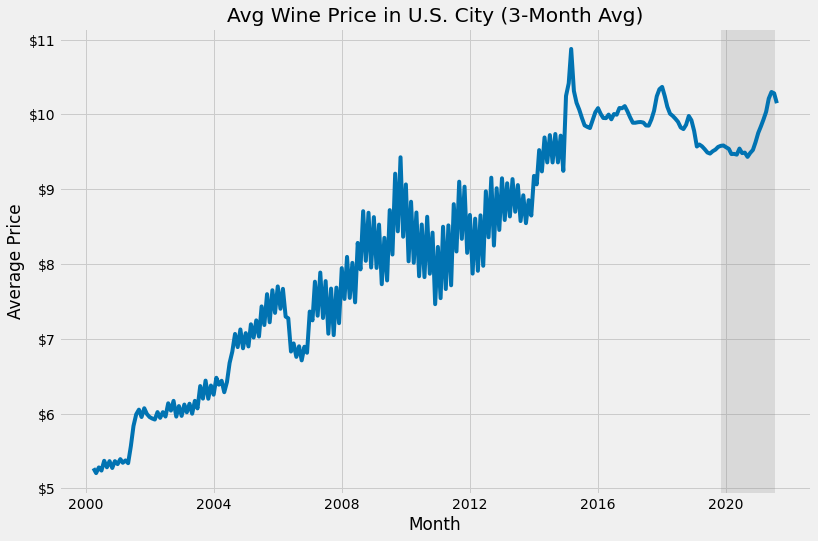

In [92]:
price_line_plot = sns.lineplot(data=train_df['price'].rolling(3).mean())
price_line_plot.set(title='Avg Wine Price in U.S. City (3-Month Avg)', ylabel='Average Price', xlabel='Month')
# shade in the timespan of the additional tariff
price_line_plot.axvspan(
    xmin=train_df['tariff'].where(train_df['tariff']).first_valid_index(), 
    xmax=train_df['tariff'].where(train_df['tariff']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
price_line_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:.0f}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/avg-wine-price-in-us-city.png')
plt.show()

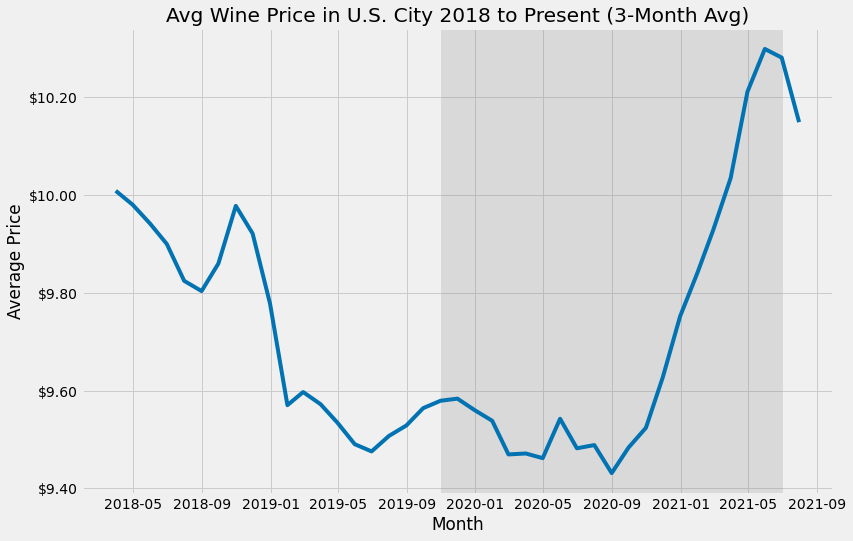

In [93]:
price_line_2018_plot = sns.lineplot(data=train_df.loc['2018-01-01':'2021-12-31']['price'].rolling(3).mean())
price_line_2018_plot.set(title='Avg Wine Price in U.S. City 2018 to Present (3-Month Avg)', ylabel='Average Price', xlabel='Month')
# shade in the timespan of the additional tariff
price_line_2018_plot.axvspan(
    xmin=train_df['tariff'].where(train_df['tariff']).first_valid_index(), 
    xmax=train_df['tariff'].where(train_df['tariff']).last_valid_index(), 
    color='gray', 
    alpha=0.2
)
price_line_2018_plot.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '${:.2f}'.format(y)))
plt.gcf().set_size_inches(12, 8)
plt.savefig('../figures/avg-wine-price-in-us-city-2018.png')
plt.show()

In [94]:
adf(train_df['price'])

Augmented Dickey-Fuller Test:
t-stat:                   -1.752900
p-value:                   0.404083
lags:                      9.000000
observations:            249.000000
critical value (1%):      -3.456888
critical value (5%):      -2.873219
critical value (10%):     -2.572994
dtype: float64


In [89]:
php_ct = PhillipsPerron(train_df['price'], trend = 'ct')
php_ct.summary()

Test Statistic,-26.432
P-value,0.000
Lags,16


In [95]:
style.use('default')

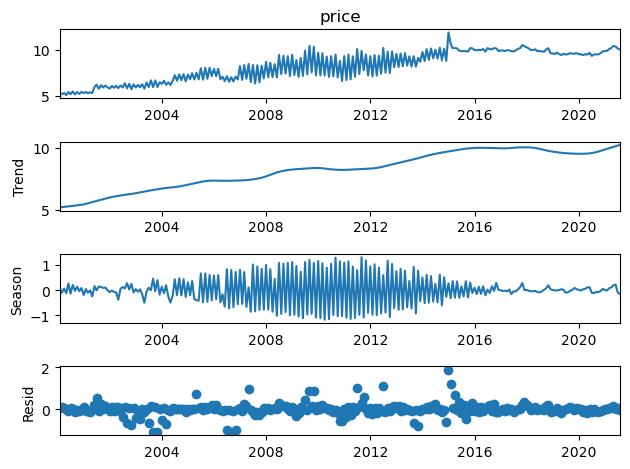

In [98]:
price_dc = STL(train_df['price'].dropna(), seasonal_deg=1, trend_deg=1, robust=True).fit()
price_dc.plot()
plt.show()

<AxesSubplot:xlabel='month'>

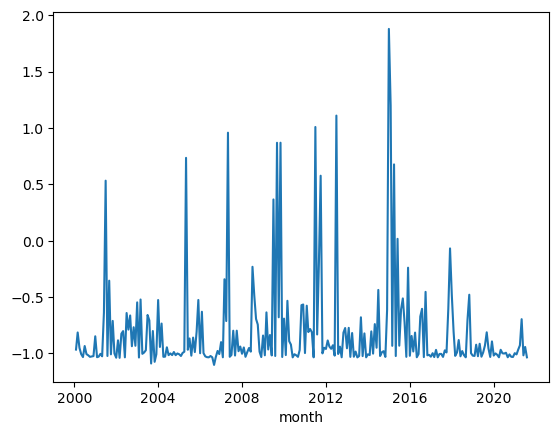

In [99]:
price_s = price_dc.observed - price_dc.seasonal - price_dc.trend - price_dc.weights

sns.lineplot(data=price_s)

In [100]:
adf(price_s)

Augmented Dickey-Fuller Test:
t-stat:                 -8.041693e+00
p-value:                 1.839725e-12
lags:                    1.000000e+00
observations:            2.570000e+02
critical value (1%):    -3.456054e+00
critical value (5%):    -2.872853e+00
critical value (10%):   -2.572799e+00
dtype: float64


In [102]:
php_ct = PhillipsPerron(price_s)
php_ct.summary()

Test Statistic,-14.877
P-value,0.000
Lags,16


In [103]:
train_df['price_seas'] = price_dc.seasonal
train_df['price_trend'] = price_dc.trend
train_df['price_weights'] = price_dc.weights
train_df['price_s'] = price_s

In [104]:
train_df.head()

,price,pop,bott,bott_pc,exp_q,exp_val,tariff,duty_val_world,q_world,cif_world,...,q_row,cif_row,duty_row,prop_row,cif_r_row,duty_r_row,price_seas,price_trend,price_weights,price_s
month,,,,,,,,,,,,,,,,,,,,,
2000-01-31,5.299029,281083000,1.244070e+08,0.442599,22385348,4.419970e+07,False,1.298947e+08,30869692,6.853057e+06,...,2402418,550866.019417,162756.310680,0.084392,0.229296,0.067747,0.090855,5.179916,0.994087,-0.965829
2000-02-29,5.198813,281299000,1.375283e+08,0.488904,20954045,4.088633e+07,False,1.389756e+08,27334547,6.089141e+06,...,2118152,504564.787339,163492.581602,0.083999,0.238210,0.077186,-0.106608,5.198646,0.920982,-0.814206
2000-03-31,5.311650,281531000,1.603837e+08,0.569684,20240059,4.023967e+07,False,1.635349e+08,33950034,7.495030e+06,...,2900608,710128.155340,191233.009709,0.093419,0.244820,0.065929,0.055213,5.218018,0.989344,-0.950924
2000-04-30,5.104950,281763000,1.423004e+08,0.505036,21745478,4.100174e+07,False,1.727178e+08,37381318,8.363492e+06,...,2577645,598792.079208,177575.247525,0.074062,0.232302,0.068890,-0.126735,5.238039,0.999719,-1.006072
2000-05-31,5.426889,281996000,1.612658e+08,0.571873,22059299,4.187646e+07,False,1.744802e+08,38726698,8.921802e+06,...,2554428,626929.342493,193309.126595,0.070618,0.245428,0.075676,0.254558,5.258682,0.945813,-1.032163
